In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**TASK: Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [3]:
df = pd.read_csv('Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


Changed the column name to Production

In [5]:
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


Ploted out the time series

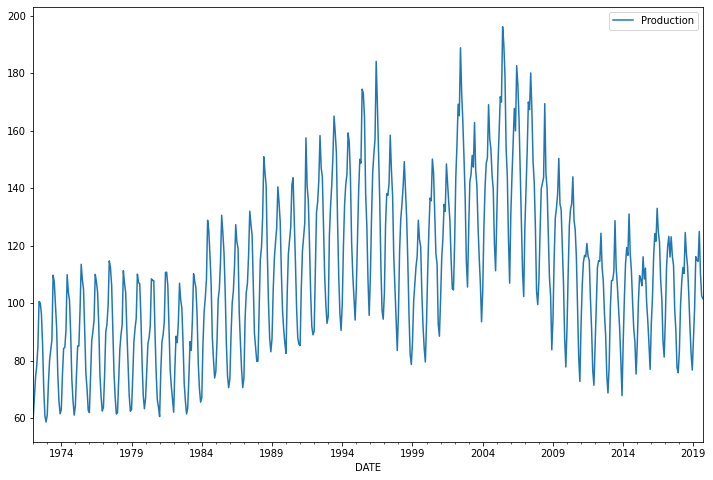

In [7]:
df.plot(figsize=(12,8))

## Train Test Split

In [8]:
len(df)

573

In [9]:
test_size = 24
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
len(test)

24

## Scale Data

Used a MinMaxScaler to scale the train and test sets into scaled versions.

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

Created a TimeSeriesGenerator object based off the scaled_train data.

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

### Create the Model

Create a Keras Sequential Model with as LSTM units 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [19]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Created a generator for the scaled test/validation set. 

In [21]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

Create an EarlyStopping callback based on val_loss.

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

Fitted the model to the generator, let the EarlyStopping dictate the amount of epochs.

In [24]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0240 - val_loss: 0.0028
Epoch 2/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 3/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 4/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 5/20
531/531 [==============================] - 4s 7ms/step - loss: 0.0031 - val_loss: 0.0112


Plot the history of the loss that occured during training.

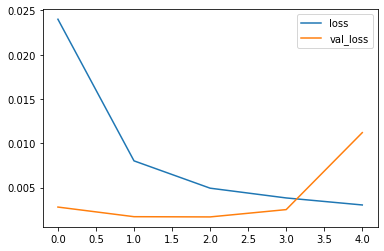

In [25]:
loss = pd.DataFrame(model.history.history)
loss.plot()

## Evaluate on Test Data

Forecast predictions for test data range (the last 12 months of the entire dataset)

In [26]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

In [28]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,101.410577
2017-11-01,77.4378,97.484305
2017-12-01,75.8118,99.914972
2018-01-01,83.4343,112.569518
2018-02-01,99.4899,125.276116
2018-03-01,107.3152,137.335623
2018-04-01,112.4309,147.096558
2018-05-01,110.3544,154.152872
2018-06-01,124.5841,156.116926


Plot  predictions versus the True test values

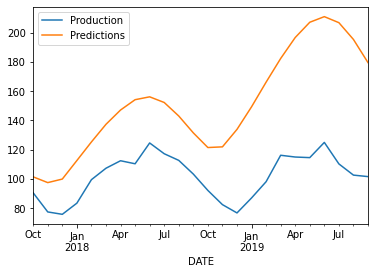

In [30]:
test.plot()

Calculate your RMSE.

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

56.179621936660645